# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,LinearSVC,DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StandardScaler,StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# create a Spark session
spark = SparkSession\
        .builder \
        .appName("last project")\
        .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [4]:
user_log.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [5]:
user_log.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
user_log.count()

286500

In [8]:
user_log.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

##### 检查是否有空的记录

In [9]:
user_log_valid = user_log.dropna(how="any",subset=["userId","sessionId"])

In [10]:
user_log_valid.count()   #和前面结果一样，没有空值

286500

In [11]:
#查看一下是否有
user_log.select("userId").dropDuplicates().sort("userId").show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



In [12]:
user_log.select("userId").dropDuplicates().count()   #共有226个用户的记录

226

In [13]:
#存在空记录，删除它们
user_log_valid=user_log_valid.filter(user_log_valid["userId"]!="")

In [14]:
user_log_valid.count()    #删除掉了部分数据

278154

##### 查看一下sessionid
user_log_valid.select("sessionId").dropDuplicates().sort("sessionId").show()    #这个没有空的

##### 按时间换算数据

1.按小时

In [15]:
#get_hour = udf(lambda x:datetime.datetime.fromtimestamp(x / 1000).hour)
#user_log_valid = user_log_valid.withColumn("hour",get_hour(user_log_valid.ts))
#user_log_valid.head()

In [16]:
get_time = udf(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime('%Y-%m-%d'))
user_log_valid = user_log_valid.withColumn("time_log",get_time(user_log_valid.ts))
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time_log='2018-10-01')

In [17]:
get_restime = udf(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime('%Y-%m-%d'))
user_log_valid = user_log_valid.withColumn("time_res",get_restime(user_log_valid.registration))
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time_log='2018-10-01', time_res='2018-09-28')

In [18]:
#user_log_valid = user_log_valid.drop('time')

In [19]:
#user_log_valid

In [20]:
user_log_valid.agg(min("time_log"), max("time_log")).show()   

+-------------+-------------+
|min(time_log)|max(time_log)|
+-------------+-------------+
|   2018-10-01|   2018-12-03|
+-------------+-------------+



可以看出数据只包含了2018年年底两个月的数据

In [21]:
user_log_valid.agg(min("time_res"), max("time_res")).show()   #注册时间的时间段

+-------------+-------------+
|min(time_res)|max(time_res)|
+-------------+-------------+
|   2018-03-18|   2018-11-26|
+-------------+-------------+



数据中的用户为2018年3月至11月注册的新用户，可以据上述信息统计出用户使用的时间长短

In [22]:
# 计算出每个用户的最后登录时间
temp1 = user_log_valid.groupby("userId").agg(max("time_log")).withColumnRenamed("max(time_log)", "latest").toPandas()

In [23]:
temp1.head()

,userId,latest
0,100010,2018-11-21
1,200002,2018-11-15
2,125,2018-10-12
3,124,2018-11-30
4,51,2018-10-17


In [24]:
dict_time = temp1.set_index("userId").to_dict()["latest"]     #转成字典

In [25]:
datetime.datetime.strptime(dict_time["51"],'%Y-%m-%d')

datetime.datetime(2018, 10, 17, 0, 0)

In [26]:
#生成一个函数  用userid查询最晚时间
latest_time = udf(lambda x:dict_time[x])
user_log_valid = user_log_valid.withColumn("latest_time", latest_time("userId"))

In [27]:
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time_log='2018-10-01', time_res='2018-09-28', latest_time='2018-11-30')

In [28]:
temp2 = user_log_valid.select("userId","time_res","latest_time").toPandas()

In [29]:
temp2.head()

,userId,time_res,latest_time
0,30,2018-09-28,2018-11-30
1,9,2018-09-30,2018-11-30
2,30,2018-09-28,2018-11-30
3,9,2018-09-30,2018-11-30
4,30,2018-09-28,2018-11-30


In [30]:
#int(((datetime.datetime.strptime(temp2["latest_time"][0],"%Y-%m-%d")-datetime.datetime.strptime(temp2["time_res"][0],"%Y-%m-%d")).days)/30)

In [31]:
# temp2["time_res"][0]

In [32]:
def trans_2time(day):
    return [datetime.datetime.strptime(day[each],"%Y-%m-%d") for each in range(len(day))]

In [33]:
temp3=list(map(lambda x,y:(y-x).days,trans_2time(temp2["time_res"]),trans_2time(temp2["latest_time"])))

In [34]:
delta_time=pd.DataFrame(temp3).rename(columns={0:"delta_time"})

In [35]:
delta_time.head()

,delta_time
0,63
1,61
2,63
3,61
4,63


In [36]:
#delta_time_sp = spark.createDataFrame(delta_time)

In [37]:
#delta_time_sp.show(5)

In [38]:
temp4 = pd.merge(temp2,delta_time,left_index=True,right_index=True)

In [39]:
temp5 = temp4[["userId","delta_time"]].rename(columns={"userId":"userId1"})

In [40]:
temp5.head()

,userId1,delta_time
0,30,63
1,9,61
2,30,63
3,9,61
4,30,63


In [41]:
temp5=spark.createDataFrame(temp5)

In [42]:
temp5.select("*").where(temp5.userId1==100010).show(5)

+-------+----------+
|userId1|delta_time|
+-------+----------+
| 100010|        55|
| 100010|        55|
| 100010|        55|
| 100010|        55|
| 100010|        55|
+-------+----------+
only showing top 5 rows



In [43]:
temp5.count()

278154

In [44]:
temp5 = temp5.distinct()

In [45]:
temp5.count()

225

In [46]:
#user_log_valid = user_log_valid.withColumn("delta_time",user_log_valid.userId*0)

In [47]:
user_log_valid3 = user_log_valid.join(temp5,user_log_valid.userId==temp5.userId1)   #把两个拼起来了    有没有什么办法可以直接把delta_time拼上来

In [48]:
user_log_valid3.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+-----------+-------+----------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|  time_log|  time_res|latest_time|userId1|delta_time|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+-----------+-------+----------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   

In [49]:
user_log_valid3 = user_log_valid3.drop('userId1')

In [50]:
user_log_valid.count()

278154

In [51]:
user_log_valid3.count()

278154

#### 用户所属区域提取

In [52]:
area_get = udf(lambda x:x.rsplit(',',1)[-1])
user_log_valid3 = user_log_valid3.withColumn("area",area_get(user_log_valid3["location"]))

In [53]:
user_log_valid3.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+-----------+----------+----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|  time_log|  time_res|latest_time|delta_time|area|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+-----------+----------+----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|15390

#### 听歌量统计

In [54]:
#先统计每个人的累积听歌量
song_count = user_log_valid3.filter(user_log_valid3.page=="NextSong").groupby("userId").agg({"userId":"count"})\
.withColumnRenamed("userId", "userId1").withColumnRenamed("count(userId)", "song_nums")

In [55]:
song_count.show(5)

+-------+---------+
|userId1|song_nums|
+-------+---------+
| 100010|      275|
| 200002|      387|
|    125|        8|
|    124|     4079|
|     51|     2111|
+-------+---------+
only showing top 5 rows



In [56]:
user_log_valid3 = user_log_valid3.join(song_count,user_log_valid3.userId==song_count.userId1).drop("userId1") 

In [57]:
user_log_valid3.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+-----------+----------+----+---------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|  time_log|  time_res|latest_time|delta_time|area|song_nums|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+-----------+----------+----+---------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Cap

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [58]:
user_log_valid3.select("page").dropDuplicates().sort("page").show()    #查看Cancellation Confirmation事件

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [59]:
user_log_valid3.filter("page='Cancellation Confirmation'").show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----------+----------+-----------+----------+---------+---------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|  time_log|  time_res|latest_time|delta_time|     area|song_nums|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----------+----------+-----------+----------+---------+---------+
|  null|Cancelled|    Mason|     M|           10|    Hart|  null| free|  Corpus Christi, TX|   GET|Cancellation Conf...|1533157139000|      174|null|   200|1539318918000|"Mozilla/5.0 (Mac...|   125|2018-10-12

In [60]:
can_con_event = udf(lambda x: 1 if x=="Cancellation Confirmation"else 0,IntegerType())
user_log_valid3 = user_log_valid3.withColumn("churn", can_con_event("page"))

In [61]:
#user_log_valid=user_log_valid.drop("losing").collect()

In [62]:
user_log_valid3.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+-----------+----------+----+---------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|  time_log|  time_res|latest_time|delta_time|area|song_nums|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+-----------+----------+----+---------+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|153801634

In [63]:
temp = user_log_valid3.select(["userId","churn"]).where(user_log_valid3.churn==1)

In [64]:
temp.count()   #流失客户共有52人

52

In [65]:
temp1 = temp.collect()   #转成list了

In [66]:
#print(temp1)   #中间的流失客户

In [67]:
temp2 = list(int(i[0]) for i in temp1)   #提取userId

In [68]:
# 18 == int(temp1[0][0])
#18 in temp2

In [69]:
user_log_valid3 = user_log_valid3.withColumn("userId",user_log_valid3.userId.astype("int"))   #前面转成int了  所以这里把userId也转成int了

In [70]:
user_log_valid3.select("userId").dtypes  #查看类型

[('userId', 'int')]

In [71]:
churn_user = udf(lambda x: 1 if x in temp2 else 0, IntegerType())
user_log_valid3 = user_log_valid3.withColumn("churn_users", churn_user("userId"))  #标记所有的流失客户

In [72]:
#user_log_valid.show(1)

In [73]:
user_log_valid3.select(["userId","churn_users","page"]).where(user_log_valid3.userId==18).show(5)

+------+-----------+--------+
|userId|churn_users|    page|
+------+-----------+--------+
|    18|          1|    Home|
|    18|          1|NextSong|
|    18|          1|NextSong|
|    18|          1|NextSong|
|    18|          1|NextSong|
+------+-----------+--------+
only showing top 5 rows



In [74]:
#另一种标记流失用户的方式(用时窗的话，更简单！)

In [75]:
#from pyspark.sql import Window
#windowval = Window.partitionBy("userId").orderBy(desc("ts"))

In [76]:
#from pyspark.sql.functions import sum as Fsum
#user_log_valid3 = user_log_valid3.withColumn("churn_users1", Fsum("churn").over(windowval))

In [77]:
#user_log_valid3.select(["userId","churn_users1","page"]).where(user_log_valid3.userId==18).show(5)

In [93]:
#user_log_valid3=user_log_valid3.drop("churn_users1")

##### 1.流失客户与性别之间的关系

In [77]:
user_log_valid1 = user_log_valid3.select("gender","userId","churn_users").distinct()

In [78]:
gender_group = user_log_valid1.groupby("gender").agg({'gender':'count'})

In [79]:
gender_group.show()

+------+-------------+
|gender|count(gender)|
+------+-------------+
|     F|          104|
|     M|          121|
+------+-------------+



In [80]:
gender_group_pd = gender_group.toPandas()

In [81]:
temp7 = gender_group_pd.sort_values(["gender"],ascending=False).reset_index(drop=True)   #记得重置索引

In [82]:
temp7     #统计每个性别的总人数

,gender,count(gender)
0,M,121
1,F,104


In [83]:
churn_gender = user_log_valid1.groupby("churn_users","gender").agg({'gender':'count'})

In [84]:
churn_gender.show()

+-----------+------+-------------+
|churn_users|gender|count(gender)|
+-----------+------+-------------+
|          1|     F|           20|
|          0|     M|           89|
|          1|     M|           32|
|          0|     F|           84|
+-----------+------+-------------+



In [85]:
churn_gender_pd = churn_gender.toPandas()

In [86]:
churn_gender_pd

,churn_users,gender,count(gender)
0,1,F,20
1,0,M,89
2,1,M,32
3,0,F,84


In [87]:
temp6=churn_gender_pd[churn_gender_pd["churn_users"]==0].reset_index(drop=True) 

In [88]:
temp6

,churn_users,gender,count(gender)
0,0,M,89
1,0,F,84


In [89]:
temp5 = churn_gender_pd[churn_gender_pd["churn_users"]==1].sort_values(by=["gender"],ascending = False).reset_index(drop=True) 

In [90]:
temp5

,churn_users,gender,count(gender)
0,1,M,32
1,1,F,20


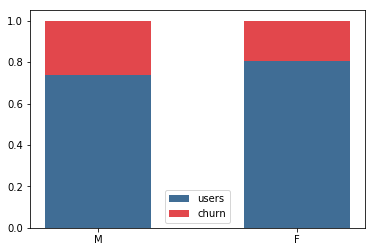

In [91]:
plt.bar([0,1.5],temp6["count(gender)"]/temp7["count(gender)"],label='users',fc = '#406D95') 
plt.bar([0,1.5],temp5["count(gender)"]/temp7["count(gender)"],bottom=temp6["count(gender)"]/temp7["count(gender)"], label='churn',tick_label = ["M","F"],fc = '#E2474C')
plt.legend()
plt.show()

对比了流失用户和现存用户的性别，可以发现男性用户流失的比例略微大一些。

##### 2.流失客户的状态(付费用户/普通用户)

In [92]:
user_log_valid2 = user_log_valid3.select("level","userId","churn_users").distinct()

In [93]:
level_group = user_log_valid2.groupby("level").agg({'level':'count'})

In [94]:
level_group.show()

+-----+------------+
|level|count(level)|
+-----+------------+
| free|         195|
| paid|         165|
+-----+------------+



In [95]:
level_group_pd = level_group.toPandas().sort_values(by=["level"]).reset_index(drop=True) 

In [96]:
level_group_pd

,level,count(level)
0,free,195
1,paid,165


In [97]:
churn_level = user_log_valid2.groupby("level","churn_users").agg({'level':'count'})

In [98]:
churn_level.show()

+-----+-----------+------------+
|level|churn_users|count(level)|
+-----+-----------+------------+
| paid|          0|         129|
| free|          0|         149|
| paid|          1|          36|
| free|          1|          46|
+-----+-----------+------------+



In [99]:
churn_level_pd = churn_level.toPandas()

In [100]:
churn_level_pd

,level,churn_users,count(level)
0,paid,0,129
1,free,0,149
2,paid,1,36
3,free,1,46


In [101]:
temp8=churn_level_pd[churn_level_pd["churn_users"]==0].sort_values(by=["level"]).reset_index(drop=True) 

In [102]:
temp8

,level,churn_users,count(level)
0,free,0,149
1,paid,0,129


In [103]:
temp9=churn_level_pd[churn_level_pd["churn_users"]==1].sort_values(by=["level"]).reset_index(drop=True) 

In [104]:
temp9

,level,churn_users,count(level)
0,free,1,46
1,paid,1,36


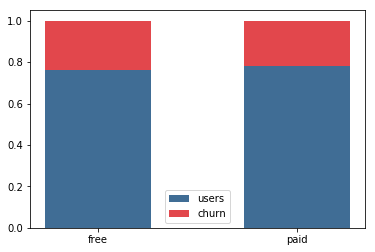

In [105]:
plt.bar([0,1.5],temp8["count(level)"]/level_group_pd["count(level)"],label='users',fc = '#406D95') 
plt.bar([0,1.5],temp9["count(level)"]/level_group_pd["count(level)"],bottom=temp8["count(level)"]/level_group_pd["count(level)"], label='churn',tick_label = ["free","paid"],fc = '#E2474C')
plt.legend()
plt.show()

可以看出付费用户和普通用户在用户流失方面并无明显差别，付费与否对用户流失的影响不大。

##### 3.用户流失与访问状态的关系

In [106]:
user_log_valid3.groupby("status").agg({"status":"count"}).show()

+------+-------------+
|status|count(status)|
+------+-------------+
|   307|        23184|
|   404|          252|
|   200|       254718|
+------+-------------+



对所有记录的访问状态做了一个统计，发现出现非正常访问的次数较多，将状态307和404标记为非正常访问

In [107]:
status_any = user_log_valid3.select("status","userId","churn_users")    #选取相关数据

In [108]:
status_any[status_any["status"]==404].distinct().show()    #初步查看问题访问中流失用户的出现频次

+------+------+-----------+
|status|userId|churn_users|
+------+------+-----------+
|   404|200024|          1|
|   404|    81|          0|
|   404|300005|          0|
|   404|    53|          1|
|   404|200007|          0|
|   404|   114|          0|
|   404|    37|          0|
|   404|   115|          0|
|   404|    39|          0|
|   404|   131|          0|
|   404|300002|          0|
|   404|    12|          1|
|   404|    71|          0|
|   404|200011|          1|
|   404|300016|          0|
|   404|    91|          0|
|   404|100025|          1|
|   404|100021|          1|
|   404|   126|          0|
|   404|300015|          0|
+------+------+-----------+
only showing top 20 rows



In [109]:
#每个用户总的记录数
count = status_any.select("userId").groupby("userId").agg({"userId":"count"}).orderBy(status_any.userId).toPandas()

In [110]:
count.head()

,userId,count(userId)
0,2,899
1,3,254
2,4,2442
3,5,218
4,6,3761


In [111]:
#按访问状态统计次数
have_try = status_any.groupby("userId","churn_users","status").agg({"status":"count"}).orderBy(status_any.userId,status_any.status)

In [112]:
have_try.show(5)

+------+-----------+------+-------------+
|userId|churn_users|status|count(status)|
+------+-----------+------+-------------+
|     2|          0|   200|          829|
|     2|          0|   307|           70|
|     3|          1|   200|          232|
|     3|          1|   307|           22|
|     4|          0|   200|         2244|
+------+-----------+------+-------------+
only showing top 5 rows



In [113]:
nor_count = have_try[have_try["status"]==200].toPandas()   #获取所有正常访问次数

In [114]:
nor_count.head()

,userId,churn_users,status,count(status)
0,2,0,200,829
1,3,1,200,232
2,4,0,200,2244
3,5,0,200,199
4,6,0,200,3469


In [115]:
nor_count["ratio"] = nor_count["count(status)"]/count["count(userId)"]   #计算正常访问比率

In [116]:
nor_count.head()

,userId,churn_users,status,count(status),ratio
0,2,0,200,829,0.922136
1,3,1,200,232,0.913386
2,4,0,200,2244,0.918919
3,5,0,200,199,0.912844
4,6,0,200,3469,0.922361


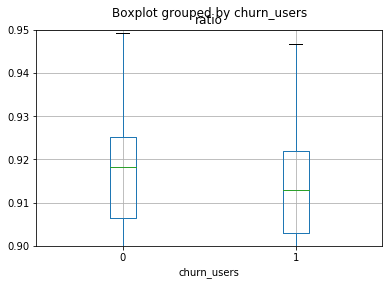

In [117]:
#箱线图对比一下
nor_count.boxplot(column="ratio",by="churn_users")
plt.ylim([0.9,0.95])
plt.show()

可以看到流失用户的正常访问比率略低于留存用户，但影响并不明显。问题访问在所有用户中出现的机率相当，访问状态对用户流失影响不大。

#### 4.用户流失与使用时间长度的关系

In [118]:
#选出需要的几个变量
use_term = user_log_valid3.select("userId","delta_time","churn_users")

In [136]:
use_term1 = use_term.dropDuplicates().toPandas()

In [137]:
use_term1.head()

,userId,delta_time,churn_users
0,134,65,0
1,33,163,0
2,200012,65,0
3,4,63,0
4,108,62,0


In [138]:
churn_useterm = use_term1[use_term1["churn_users"]==1]

In [139]:
ichurn_useterm = use_term1[use_term1["churn_users"]==0]

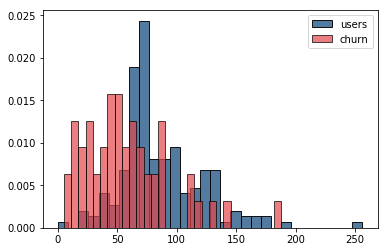

In [140]:
plt.hist(ichurn_useterm["delta_time"],bins=30,normed=1,facecolor='#406D95',edgecolor="black",label="users",alpha=0.9)
plt.hist(churn_useterm["delta_time"],bins=30,normed=1,facecolor='#E2474C',edgecolor="black",label="churn",alpha=0.7)
#plt.hist(ichurn_useterm["delta_time"],bins=20,normed=1,facecolor='#406D95',edgecolor="black",label="users",alpha=0.8)
plt.legend()
plt.show()

可以看到流失用户的使用时间长主要集中于50天以下，而现存用户的使用时间长度集中于75天左右，且长天数用户居多。平台用于巩固新用户的时间应在2个月以内。

#### 5.流失用户与听歌量之间的关系

In [84]:
#先统计每个人的累积听歌量
#song_count = user_log_valid3.filter(user_log_valid3.page=="NextSong").groupby("userId").agg({"userId":"count"})\
#.withColumnRenamed("userId", "userId1").withColumnRenamed("count(userId)", "song_nums")

In [85]:
# song_count.show(5)

In [86]:
# user_log_valid3 = user_log_valid3.join(song_count,user_log_valid3.userId==song_count.userId1).drop("userId1")  

In [87]:
# user_log_valid3.show(5)

In [88]:
song_any = user_log_valid3.select("userId","churn_users","song_nums").dropDuplicates().toPandas()

In [89]:
song_any.head()

,userId,churn_users,song_nums
0,6,0,3159
1,149,0,186
2,300024,0,88
3,94,0,146
4,111,0,698


In [90]:
churn_songnum = song_any[song_any["churn_users"]==1]

In [91]:
ichurn_songnum = song_any[song_any["churn_users"]==0]

In [92]:
churn_songnum.head()

,userId,churn_users,song_nums
6,58,1,1694
13,200016,1,206
15,200024,1,417
31,100012,1,476
38,100025,1,490


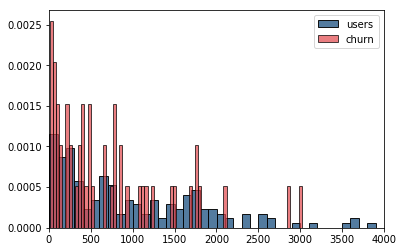

In [93]:
plt.hist(ichurn_songnum["song_nums"],bins=80,normed=1,facecolor='#406D95',edgecolor="black",label="users",alpha=0.9)
plt.hist(churn_songnum["song_nums"],bins=80,normed=1,facecolor='#E2474C',edgecolor="black",label="churn",alpha=0.7)
#plt.hist(churn_songnum["song_nums"],bins=20,normed=1,facecolor='#E2474C',edgecolor="black",label="churn",alpha=0.7)
plt.xlim(0, 4000)
plt.legend()
plt.show()

可以看出现存用户听歌总数分布较为连续，流失用户听歌量在1000以下的较多。

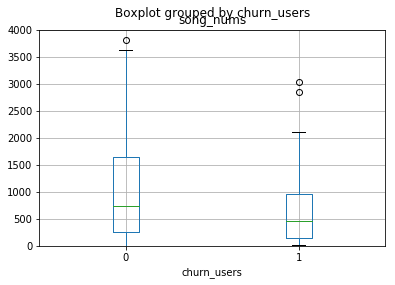

In [94]:
#箱线图对比一下
song_any.boxplot(column="song_nums",by="churn_users")
plt.ylim([0,4000])
plt.show()

可以看出流失用户的总听歌量分布区间低于现存用户，听歌量一定程度可以展现用户对平台的使用次数。

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [75]:
#选择需要的数据，选择了性别，地区，注册时间长度，累计听歌数等变量，以及标签列(churn_users)
data_pre = user_log_valid3.select("gender","area","delta_time","song_nums","churn_users")
data_pre = data_pre.withColumnRenamed('churn_users', 'label')
# data_pre = data_pre.withColumn('song_nums1', data_pre["song_nums"].cast("Int"))
# data_pre = data_pre.withColumn('delta_time1', data_pre["delta_time"].cast("Int"))
#其中性别，地区均为字符串，需要转换
areaIndexer = StringIndexer(inputCol='area', outputCol='area_feature')
genderIndexer = StringIndexer(inputCol='gender', outputCol='gender_feature')
#生成向量
assembler = VectorAssembler(inputCols=['area_feature', 'gender_feature','song_nums', 'delta_time'], outputCol='features1')
#song_nums数据区间变化过大，进行归一化
Scaler = StandardScaler(inputCol='features1', outputCol='features')



#生成特征处理的pipeline
pipeline = Pipeline(stages = [areaIndexer,genderIndexer,assembler,Scaler])

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [76]:
train00 , test0 = data_pre.randomSplit([0.8,0.2],seed=24)
train0 , validation0 = train00.randomSplit([0.8,0.2],seed = 24)

train = pipeline.fit(train0).transform(train0)
test = pipeline.fit(test0).transform(train0)
validation = pipeline.fit(test0).transform(train0)


In [79]:
#创建模型1
lr = LogisticRegression(maxIter=20)
paramGrid1 = ParamGridBuilder().addGrid(lr.regParam, [0.3, 0.01]).addGrid(lr.elasticNetParam, [1.0, 0.0]).build()  #为1时L1,0时L2
evaluator1=MulticlassClassificationEvaluator(metricName="f1")
crossval = CrossValidator(estimator=lr, 
                          estimatorParamMaps=paramGrid1, 
                          evaluator=evaluator1, 
                          numFolds=3)
lr_model = crossval.fit(train)
print('lrpre value: {}'.format(evaluator1.evaluate(lr_model.transform(validation))))

lrpre value: 0.7835692793395331


In [80]:
lr_model.getEstimatorParamMaps()
# lr_model.bestModel
# lr_model.avgMetrics

[{Param(parent='LogisticRegression_f3111630aa62', name='regParam', doc='regularization parameter (>= 0).'): 0.3,
  Param(parent='LogisticRegression_f3111630aa62', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0},
 {Param(parent='LogisticRegression_f3111630aa62', name='regParam', doc='regularization parameter (>= 0).'): 0.3,
  Param(parent='LogisticRegression_f3111630aa62', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
 {Param(parent='LogisticRegression_f3111630aa62', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
  Param(parent='LogisticRegression_f3111630aa62', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0},
 {P

In [81]:
lr_model.bestModel

LogisticRegressionModel: uid = LogisticRegression_f3111630aa62, numClasses = 2, numFeatures = 4

In [82]:
lr_model.avgMetrics

[0.7659299194608996,
 0.7659299194608996,
 0.7708713154360991,
 0.7839986766681151]

In [108]:
def getBestParam(cvModel):
    params = cvModel.getEstimatorParamMaps()
    avgMetrics = cvModel.avgMetrics

    all_params = list(zip(params, avgMetrics))
    best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]
    return best_param

best_param = getBestParam(lr_model)[0]

for p, v in best_param.items():
    print("{} : {}".format(p.name, v))

# print(best_param)

regParam : 0.01
elasticNetParam : 0.0


In [109]:
# 查看最佳模型参数
param_maps = lr_model.getEstimatorParamMaps()
eval_metrics = lr_model.avgMetrics

param_res = []

for params, metric in zip(param_maps, eval_metrics):
    param_metric = {}
    for key, param_val in zip(params.keys(), params.values()):
        param_metric[key.name]=param_val
    param_res.append((param_metric, metric))

sorted(param_res, key=lambda x:x[1], reverse=True)

[({'regParam': 0.01, 'elasticNetParam': 0.0}, 0.782372189637244),
 ({'regParam': 0.01, 'elasticNetParam': 1.0}, 0.7737210164191914),
 ({'regParam': 0.3, 'elasticNetParam': 1.0}, 0.7659301393783048),
 ({'regParam': 0.3, 'elasticNetParam': 0.0}, 0.7659301393783048)]

In [85]:
#创建模型2
lsvc = LinearSVC(maxIter=5)
#paramGrid2 = ParamGridBuilder().addGrid(lsvc.regParam, [0.3, 0.01]).addGrid(lsvc.maxIter, [10, 5]).build()  
paramGrid2 = ParamGridBuilder().addGrid(lsvc.regParam, [0.3, 0.01]).build() 
evaluator2 = MulticlassClassificationEvaluator(metricName="f1")
crossval1 = CrossValidator(estimator=lsvc, 
                          estimatorParamMaps=paramGrid2, 
                          evaluator=evaluator2, 
                          numFolds=3)
lsvc_model = crossval1.fit(train)
print('lsvcpre value: {}'.format(evaluator2.evaluate(lsvc_model.transform(validation))))

lsvcpre value: 0.7659303893455515


In [86]:
lsvc_model.getEstimatorParamMaps()

[{Param(parent='LinearSVC_a7bf8251d265', name='regParam', doc='regularization parameter (>= 0).'): 0.3},
 {Param(parent='LinearSVC_a7bf8251d265', name='regParam', doc='regularization parameter (>= 0).'): 0.01}]

In [87]:
lsvc_model.bestModel

LinearSVC_a7bf8251d265

In [88]:
lsvc_model.avgMetrics

[0.7659299194608996, 0.7659299194608996]

In [110]:
#创建模型3
dectree = DecisionTreeClassifier()
paramGrid3 = ParamGridBuilder().addGrid(dectree.maxDepth,[3,5,6,8]).build()  
evaluator3 = MulticlassClassificationEvaluator(metricName="f1")
crossval2 = CrossValidator(estimator=dectree, 
                          estimatorParamMaps=paramGrid3, 
                          evaluator=evaluator3, 
                          numFolds=3)
dectree_model = crossval2.fit(train)
print('dectpre value: {}'.format(evaluator3.evaluate(dectree_model.transform(validation))))

dectpre value: 0.9729793173462971


In [112]:
# 查看最佳模型参数
param_maps = dectree_model.getEstimatorParamMaps()
eval_metrics =dectree_model.avgMetrics

param_res = []

for params, metric in zip(param_maps, eval_metrics):
    param_metric = {}
    for key, param_val in zip(params.keys(), params.values()):
        param_metric[key.name]=param_val
    param_res.append((param_metric, metric))

sorted(param_res, key=lambda x:x[1], reverse=True)

[({'maxDepth': 8}, 0.987264293703346),
 ({'maxDepth': 6}, 0.9603186129162542),
 ({'maxDepth': 5}, 0.9386721329221319),
 ({'maxDepth': 3}, 0.8974656521358177)]

In [113]:
#可以看到决策树在验证集的应用效果最好，所以将其运用到测试集
print('final dectpre value: {}'.format(evaluator3.evaluate(dectree_model.transform(test))))   

final dectpre value: 0.9729793173462971


# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。